### Укажите пакеты

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re 
import seaborn as sns
import pickle as pkl


from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.decomposition import *
from pprint import pprint
from sklearn.preprocessing import *
from sklearn.neighbors import *
from sklearn.model_selection import *
from sklearn.linear_model import *
from sklearn.ensemble import *
from sklearn.svm import *
from sklearn.metrics import *
from sklearn.tree import *
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer



**Загрузим данные и сделаем задачу бинарной классификации**

In [2]:
X_tr = pd.read_csv('train.csv')
y_tr = pd.read_csv('train_Y.csv').values.reshape(-1)

In [3]:
X_tr

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,13,2017,June,23,6,0,1,1,0.0,...,No Deposit,NaN,534.0,0,Transient-Party,90.00,0,0,Check-Out,2017-06-07
1,City Hotel,100,2015,October,42,16,0,1,2,0.0,...,Non Refund,6.0,NaN,0,Transient,108.00,0,0,Canceled,2015-09-28
2,City Hotel,0,2015,October,43,20,0,1,2,0.0,...,No Deposit,3.0,NaN,0,Transient,97.00,0,0,Canceled,2015-10-20
3,Resort Hotel,125,2017,April,14,3,2,5,2,0.0,...,No Deposit,40.0,NaN,0,Contract,40.95,0,1,Check-Out,2017-04-10
4,City Hotel,104,2017,June,24,11,2,3,2,0.0,...,No Deposit,28.0,NaN,0,Transient,112.50,0,0,Check-Out,2017-06-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29842,City Hotel,142,2017,August,33,16,0,4,2,0.0,...,No Deposit,9.0,NaN,0,Transient,125.00,0,0,Canceled,2017-03-31
29843,Resort Hotel,0,2016,October,44,23,2,4,2,0.0,...,No Deposit,96.0,NaN,0,Group,46.00,0,1,Check-Out,2016-10-29
29844,City Hotel,451,2017,July,28,12,0,3,2,0.0,...,No Deposit,229.0,NaN,0,Transient-Party,112.67,0,1,Check-Out,2017-07-15
29845,City Hotel,422,2016,September,38,16,0,2,2,0.0,...,No Deposit,1.0,NaN,379,Transient-Party,90.00,0,1,Check-Out,2016-09-18


**Внимане!** Применяется обязательная стратегия заполнения пропущенных данных:
- числовых - средними `mean`,
- категориальных - наиболее часто встречающимися `most_frequent` 

Посмотрите  `SimpleImputer` [тут...](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html). В трансформере заполняет пропущенные данные.

Код в качестве примера

`make_pipeline(
    SimpleImputer(strategy="most_frequent", fill_value="NA"),
    OneHotEncoder(handle_unknown='ignore')
)`

или

`make_pipeline(
    SimpleImputer(strategy="mean"), 
    StandardScaler()
)`

Итоговая метрика ROC-AUC

In [4]:
# обязательное наименование контейнера `pipe` 
# предсказание на полном объеме данных X_t

In [5]:
X_tr = X_tr.drop(["reservation_status_date"], axis = 1)

In [6]:
X_tr, X_te, y_tr, y_te = train_test_split(X_tr, y_tr, test_size = 0.3, shuffle = True, random_state = 42)

In [7]:
X_tr.reset_index(drop=True, inplace=True)
X_te.reset_index (drop=True, inplace=True)

In [8]:
def missing_percents(data):
    percents = data.isnull().sum() / len(data)
    data = percents.sort_values()
    return data

In [9]:
missing_percents(X_tr)

hotel                             0.000000
required_car_parking_spaces       0.000000
adr                               0.000000
customer_type                     0.000000
days_in_waiting_list              0.000000
deposit_type                      0.000000
booking_changes                   0.000000
assigned_room_type                0.000000
reserved_room_type                0.000000
previous_bookings_not_canceled    0.000000
previous_cancellations            0.000000
is_repeated_guest                 0.000000
total_of_special_requests         0.000000
distribution_channel              0.000000
meal                              0.000000
babies                            0.000000
children                          0.000000
adults                            0.000000
stays_in_week_nights              0.000000
stays_in_weekend_nights           0.000000
arrival_date_day_of_month         0.000000
arrival_date_week_number          0.000000
arrival_date_month                0.000000
arrival_dat

In [10]:
X_tr = X_tr.drop(["company"], axis=1)
X_te = X_te.drop(["company"], axis=1)

In [11]:
categorical_features = ["hotel", "arrival_date_month", "arrival_date_week_number", "arrival_date_day_of_month", "meal", "country", "market_segment", "distribution_channel", "reserved_room_type", "assigned_room_type", "deposit_type", "customer_type", "reservation_status"]
real_features       = X_tr.drop(categorical_features, axis=1).columns

,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
lead_time,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
arrival_date_year,0.038737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
arrival_date_week_number,0.127746,-0.545037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
arrival_date_day_of_month,-0.000135,0.006875,0.065642,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
stays_in_weekend_nights,0.096583,0.024226,0.009446,-0.012161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
stays_in_week_nights,0.163786,0.027136,0.011657,-0.029498,0.494786,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
adults,0.109523,0.020724,0.028931,-0.004540,0.080449,0.086852,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
children,-0.029614,0.060576,0.006335,0.018419,0.038656,0.042414,0.025524,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
babies,-0.028647,0.000026,-0.000813,0.004897,0.007430,0.003337,0.020582,0.018296,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
is_repeated_guest,-0.129532,0.028135,-0.040043,-0.010269,-0.095005,-0.107533,-0.139205,-0.034791,-0.009852,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


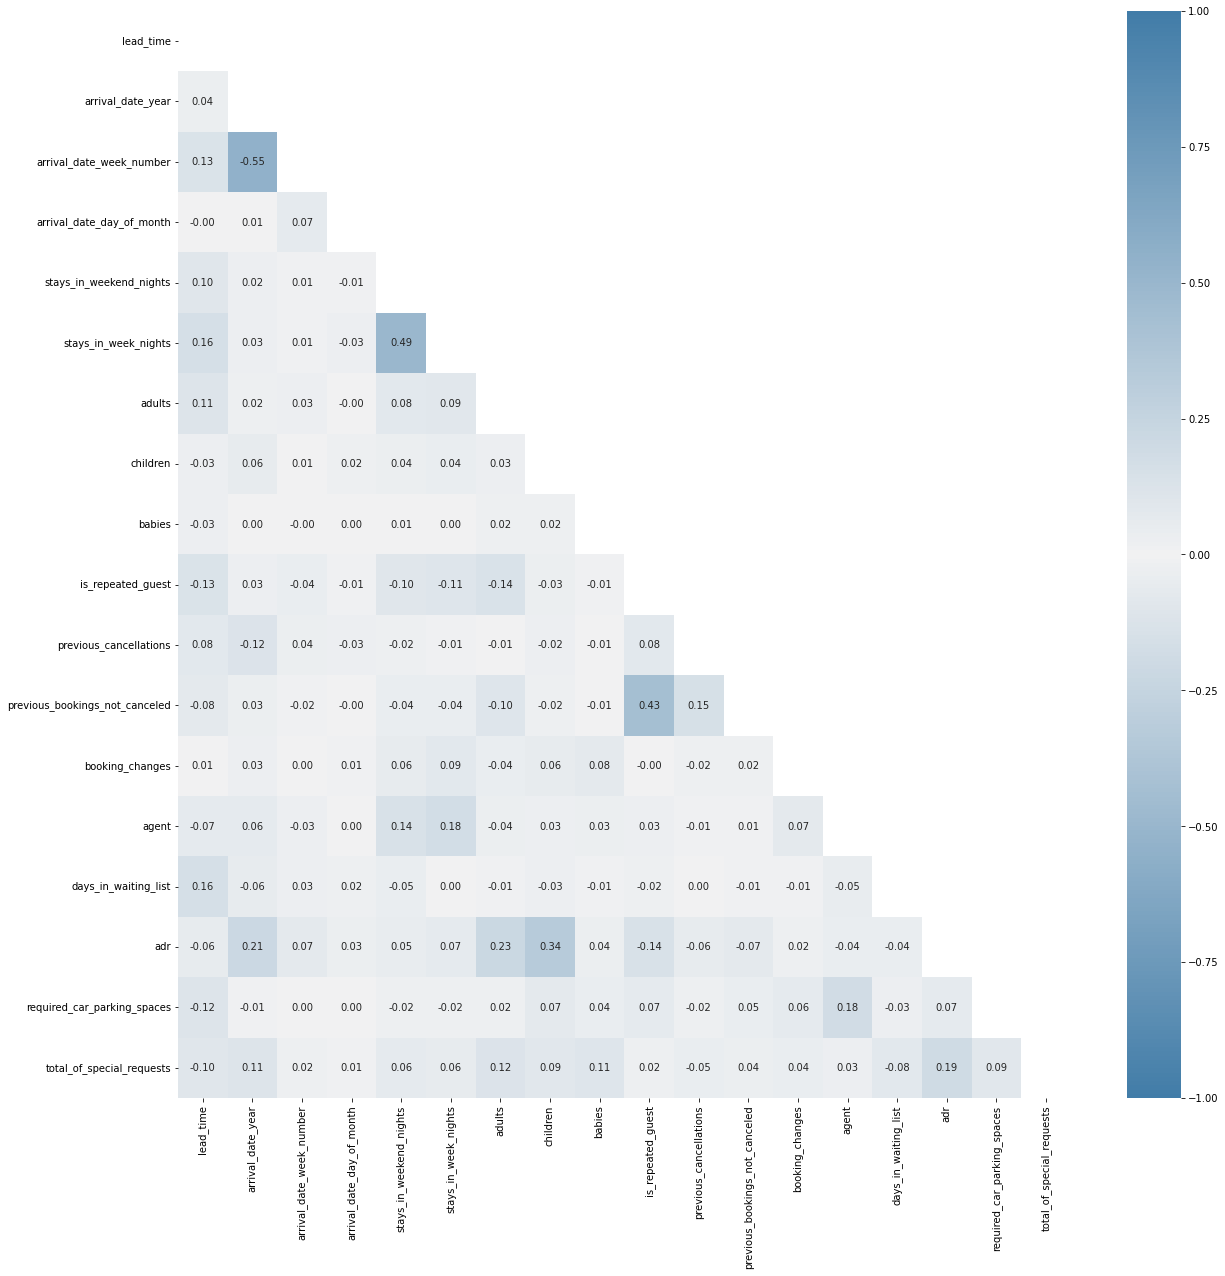

In [12]:
plt.figure(figsize=(20,20))

corr_matrix = X_tr.corr()
mask = np.tril(corr_matrix, k = -1).astype(bool)
display(corr_matrix.where(mask))

mymap = sns.diverging_palette(240, 240, as_cmap = True)

sns.heatmap(corr_matrix.where(mask), vmin = -1, vmax = 1,
            annot=True, fmt='.2f', center=0, cmap=mymap);

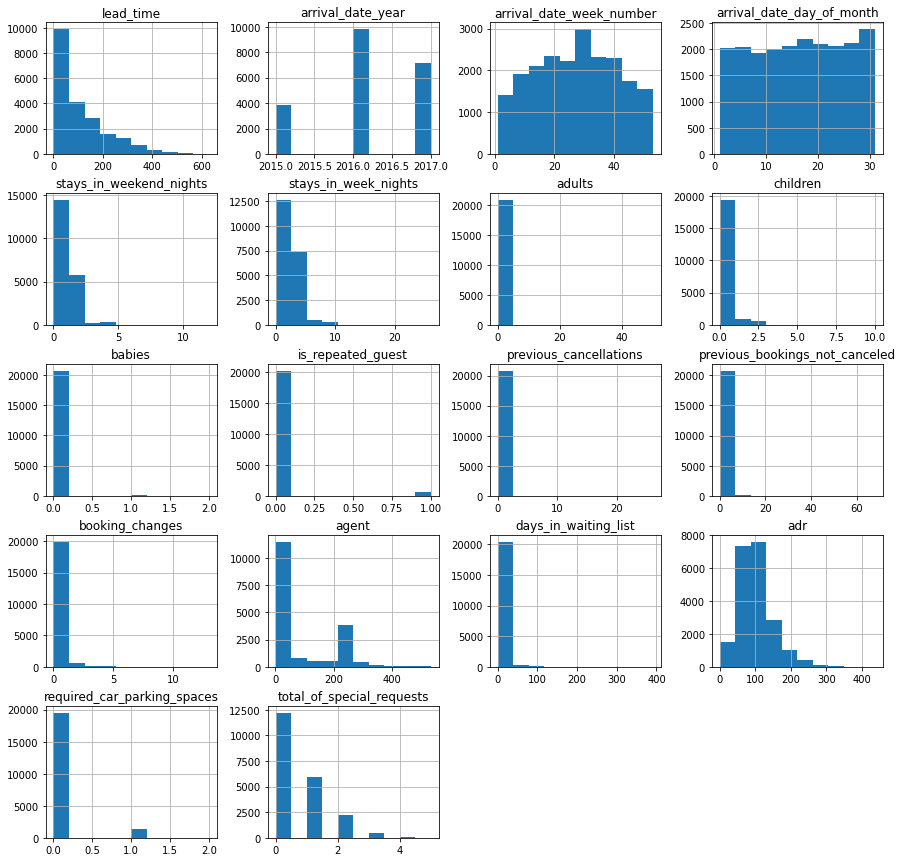

In [13]:
X_tr.hist(figsize=(15, 15));

In [14]:
imp_mean = SimpleImputer(missing_values = np.nan, strategy='mean')
imp_mean.fit(X_tr.drop(categorical_features, axis=1))

imp_frequent = SimpleImputer(missing_values = np.nan, strategy="most_frequent")
imp_frequent.fit(X_tr[categorical_features])

X_tr[real_features] = imp_mean.transform(X_tr[real_features])
X_tr[categorical_features] = imp_frequent.transform(X_tr[categorical_features])

X_te[real_features] = imp_mean.transform(X_te[real_features])
X_te[categorical_features] = imp_frequent.transform(X_te[categorical_features])

In [15]:
onehot = OneHotEncoder(handle_unknown = 'ignore')
onehot.fit(X_tr[categorical_features])
X_tr = pd.concat([pd.DataFrame(onehot.transform(X_tr[categorical_features]).toarray()), X_tr], axis=1)
X_te = pd.concat([pd.DataFrame(onehot.transform(X_te[categorical_features]).toarray()), X_te], axis=1)

In [16]:
X_tr = X_tr.drop(categorical_features, axis=1)
X_te = X_te.drop(categorical_features, axis=1)

In [17]:
forest = RandomForestClassifier(random_state=0)

forest.fit(X_tr.values, y_tr)
roc_auc_score(y_te, forest.predict(X_te.values))

1.0

# Test

In [18]:
forest = RandomForestClassifier(random_state=0)

forest.fit(pd.concat([X_tr, X_te], axis=0).values, np.concatenate([y_tr, y_te]))

RandomForestClassifier(random_state=0)

In [19]:
X_test = pd.read_csv("test.csv")

In [20]:
X_test = X_test.drop(["reservation_status_date"], axis = 1)
X_test = X_test.drop(["company"], axis = 1)

In [21]:
X_test[real_features] = imp_mean.transform(X_test[real_features])
X_test[categorical_features] = imp_frequent.transform(X_test[categorical_features])

In [22]:
X_test = pd.concat([pd.DataFrame(onehot.transform(X_test[categorical_features]).toarray()), X_test], axis=1)
X_test = X_test.drop(categorical_features, axis=1)

In [23]:
y_predict = forest.predict(X_test.values)